# CNNによる画像認識（CIFAR10, PyTorch実装）


---
## 目的
CIFAR10 Datasetを用いて10クラスの物体認識を行う．プログラムの構成は，MNISTによる文字認識のプログラムと同様になっているため，基礎的な説明はそちらを参照して頂きたい．このページでは，MNISTによる文字認識のプログラムとの差分について書いていく．

GPUを用いたネットワークの計算を行う．


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


## 使用するデータセット

### データセット
今回の物体認識では，CIFAR10データセットを用いる．CIFAR10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットである．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [1]:
# モジュールのインポート
from time import time
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットの読み込みと確認
学習データ（CIFAR10データセット）を読み込みます．

読み込んだ学習データのサイズを確認します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．
これは32x32ピクセルのカラー画像という意味になります．

In [2]:
train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transforms.ToTensor(), download=True)

print(train_data)
print(test_data)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()


### CIFAR10データセットの表示
CIFAR10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

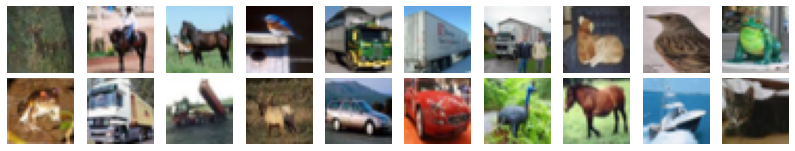

In [3]:
import matplotlib.pyplot as plt

cols = 10
rows = 2

plt.clf()
fig = plt.figure(figsize=(14, 4.8))
for r in range(rows):
    for c in range(cols):
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(train_data[c+r*cols][0].permute(1, 2, 0))
        ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

1層目の畳み込み層は入力チャンネル数が1，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．
2層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．
１つ目の全結合層は入力ユニット数は`7*7*32`とし，出力は1024としています．
次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．
また，活性化関数として`self.act`にシグモイド関数を定義します．
さらに，プーリング処理を行うための`self.pool`を定義します．
ここでは，maxpoolingを使用します．
これらの各層の構成を`__init__`関数で定義します．

次に，`forward`関数では，定義した層を接続して処理するように記述します．
`forward`関数の引数`x`は入力データです．
それを`__init__`関数で定義した`conv1`に入力し，その出力を活性化関数である`self.act`に与えます．
そして，その出力を`self.pool`に与えて，プーリング処理結果を`h`として出力します．
2層目の畳み込み層でも同様の手順で処理を行います．

畳み込みを適用した後の特徴マップを全結合層へと入力して，識別結果を出力します．
まず．畳み込みによって得られた特徴マップの形状（チャンネルx縦x横）を1次元の配列へと変換します．
ここで，`view()`を用いることで，`h`の配列を操作します．引数として，変換したい配列のサイズを入力します．
まず一つ目の引数の`h.size()[0]`で，`h`の1次元目のサイズを取得し，変換後の配列の1次元目のサイズとして指定します．
二つ目の引数の`-1`で任意のサイズを指定します．
これにより，`h`を（バッチ数x任意の長さのデータ）の形状へ変換します．
変換した`h`を全結合層および活性化関数へと順次入力することで，最終的にクラススコアを返します．

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8 * 8 * 32, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

`CNN`クラスを呼び出して，ネットワークモデルを定義します．
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します．
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

In [5]:
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                 [-1, 1024]       2,098,176
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 3,163,114
Trainable params: 3,163,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を10とします．

次にデータローダーを定義します．
データローダーでは，上で読み込んだデータセット（`train_data`）を用いて，for文で指定したミニバッチサイズでデータを読み込むオブジェクトを作成します．
この時，`shuffle=True`と設定することで，読み込むデータを毎回ランダムに指定します．

次に，誤差関数を設定します．
今回は，分類問題をあつかうため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルにimageを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [6]:
# ミニバッチサイズ・エポック数の設定
batch_size = 64
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)
        
        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_loader),
                                                                                 time() - start))

epoch: 1, mean loss: 1.9157035353088379, mean accuracy: 19.226342710997443, elapsed_time :9.047792911529541
epoch: 2, mean loss: 1.44449051361084, mean accuracy: 30.685421994884912, elapsed_time :17.435391902923584
epoch: 3, mean loss: 1.2193659086608886, mean accuracy: 35.9462915601023, elapsed_time :26.537408590316772
epoch: 4, mean loss: 1.0385089831542968, mean accuracy: 40.36061381074169, elapsed_time :34.95672917366028
epoch: 5, mean loss: 0.8850005652999878, mean accuracy: 43.99616368286445, elapsed_time :43.55858039855957
epoch: 6, mean loss: 0.7534181861877441, mean accuracy: 46.930946291560105, elapsed_time :51.97905969619751
epoch: 7, mean loss: 0.6175283567810058, mean accuracy: 49.93989769820972, elapsed_time :60.43682646751404
epoch: 8, mean loss: 0.49582964181900024, mean accuracy: 52.74680306905371, elapsed_time :69.06900072097778
epoch: 9, mean loss: 0.3591376621437073, mean accuracy: 55.846547314578004, elapsed_time :77.44472289085388
epoch: 10, mean loss: 0.267903048

## テスト
学習したネットワークモデルを用いて評価を行います．

In [52]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / 10000.))

test accuracy: 0.6946


## 課題

### 1. ネットワークの構造を変更し，認識精度の変化を確認しましょう．

**ヒント：ネットワーク構造の変更としては，次のようなものが考えられます．**
* 中間層のユニット数，畳み込みのカーネルサイズ
* 層の数
* 活性化関数
  * `nn.Tanh()`や`nn.ReLU()`, `nn.LeakyReLU()`などが考えられます．
  * その他のPyTorchで使用できる活性化関数は[こちらページ](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)にまとめられています．


### 2. 学習の設定を変更し，認識精度の変化を確認しましょう．

**ヒント：プログラムの中で変更で切る設定は次のようなものが存在します．**
* ミニバッチサイズ
* 学習回数（Epoch数）
* 学習率
* 最適化手法
  * `torch.optim.Adagrad()`や`torch.optim.Adam()`などが考えられます．
  * PyTorchで使用できる最適化手法は[こちらのページ](https://pytorch.org/docs/stable/optim.html#algorithms)にまとめられています．


# 独自の画像データを用いた推論
学習は前述の「CNNによる画像認識（CIFAR10,Pytorch実装）」で実行してください。

前述で学習を行ったモデルを用いて、独自の画像データを用いて推論を行います。

## Google Driveの同期
"Mounted at /content/drive"と表示されれば、正常にマウントできています．

現在接続しているサーバ内の/content/driveに自身のGoogle Drive（マイドライブ）をマウントしています．


In [1]:
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Mounted at /content/drive


## モジュールのインポート

In [75]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torchsummary
import os
from PIL import Image
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## ラベルリストの設定
CIFAR10のラベルリストを設定する。

In [76]:
label_names = np.array([
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"])

## 独自の画像データの読み込み
Google Driveのマイドライブに推論させたい画像をアップロードしておきます。

ori_pathにアップロードした画像のパスを記述します。画像が表示されれば読み込み成功です。

test image path: /content/drive/MyDrive/sample.png


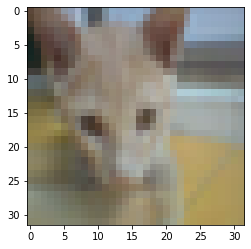

In [77]:
ori_path = "MyDrive/sample.png"

ori_path = os.path.join(drive_path, ori_path)
print("test image path: {}".format(ori_path))

ori_image = Image.open(ori_path).convert('RGB').resize((32, 32))
plt.imshow(ori_image)
plt.show()

transform = transforms.Compose([transforms.ToTensor()])
image = transform(ori_image).unsqueeze(0)

## 独自データでの推論

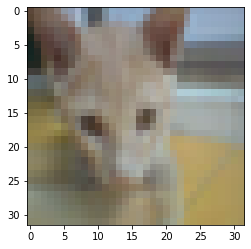

pred label: cat


In [78]:
# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
  if use_cuda:
    image = image.cuda()
    
  y = model(image)
  pred = torch.argmax(y, dim=1)

plt.imshow(ori_image)
plt.show()

print("pred label: {}".format(label_names[pred.item()]))